# Data Normalization: Comparing Police Violence in North America

## Learing Outcomes:
1) Understand how data normalization impacts the way we perceive patterns in a dataset

2) Understand different data clasification methods and how they impact the way we percieve patterns in a dataset

3) Revisit measurement scales, how are they related to classification methods

4) Using data nomralization and classification to create indices

5) Chloropleth mapping!!

# Content Warning:
* This lecture/workshop deals with a dificult and painful subject that may be triggering to some people.  The datasets we're using today describe incedents of police killings in Canada and the United States


## Pre-Lecture Poll questions:

### 1) In which country has a higher frequency of police violence?
    A) Canada
    B) The United States
    C) They're about equal
    
### 2) Which country has a greater racial disparity in incidetns of police violence?
    A) Canada
    B) The United States
    C) They're about equal
    
    
### 3) In which country are victims of police violence more likely to be unarmed?
    A) Canada
    B) The United States
    C) They're about equal

In [22]:
## This module aggregates the data into a format that's easy for us to work with
import ParseData
import numpy as np
## We'll use maptloltib to make some plots
import matplotlib.pyplot as plt
%matplotlib notebook


## Calling "GetData" does all of our prepprocessing
Data = ParseData.GetData()

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# First, we'll look at the Candaian Data


This data was collected by the CBC.  It is not an official count.  The numbers are likely underreported and there are a number of missing variables.


* ### 1) The total number of police killings between January 2000 - June 2020

* ### 2) The racial breakdown of police killings for each country.
    * Demographic groups are not evenly represented in the populations
    * This skews the breakdown and makes it look like white people are more likely to experience police violicne
        * However: Canada is about 75% white, so this is doesn't tell the full story
        
* ### 3) The racial breakdown of police killings for each country.
    * Demographic groups are not evenly represented in the populations
    * This skews the breakdown and makes it look like white people are more likely to experience police violicne
        * However: Canada is about 75% white, so this is doesn't tell the full story

<IPython.core.display.Javascript object>


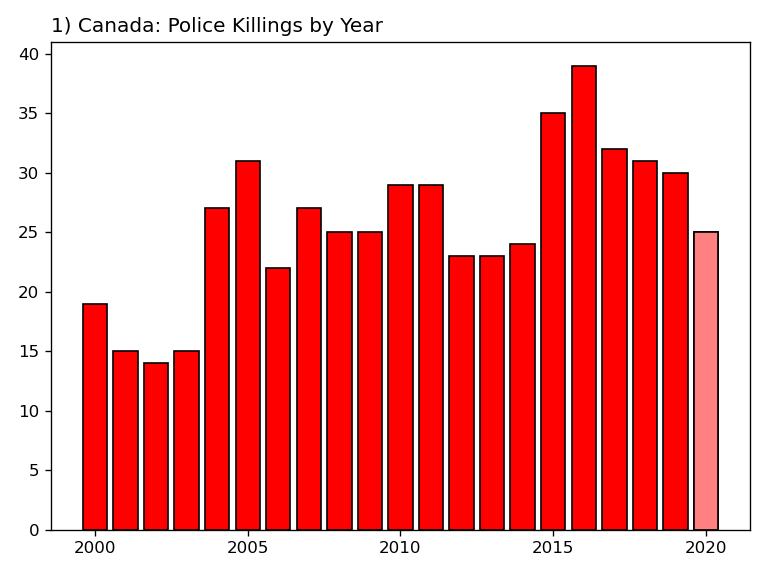

<IPython.core.display.Javascript object>


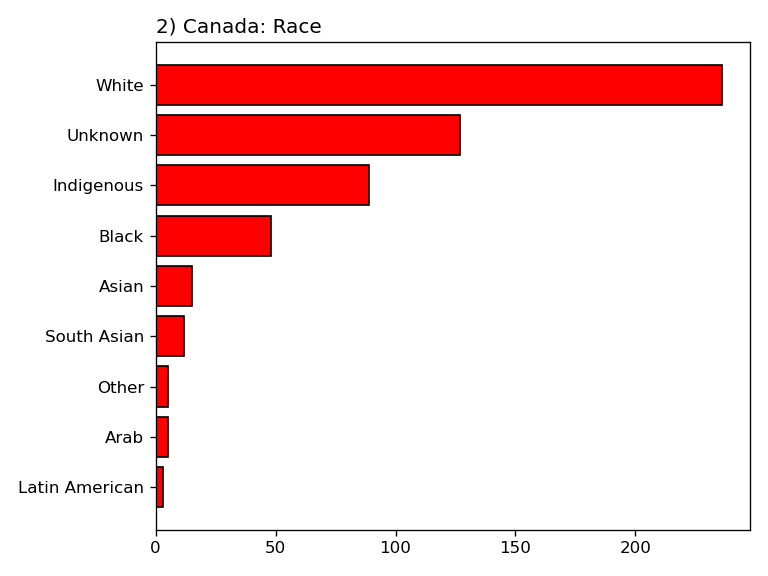

<IPython.core.display.Javascript object>


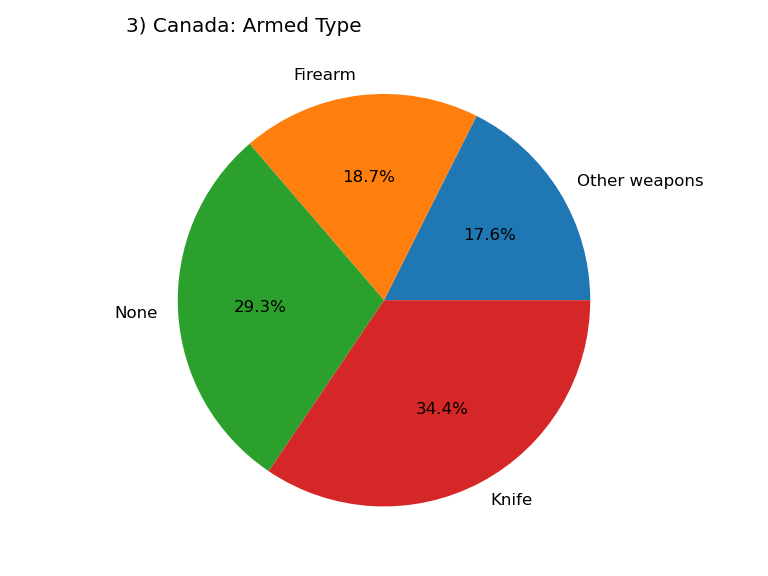

<IPython.core.display.Javascript object>


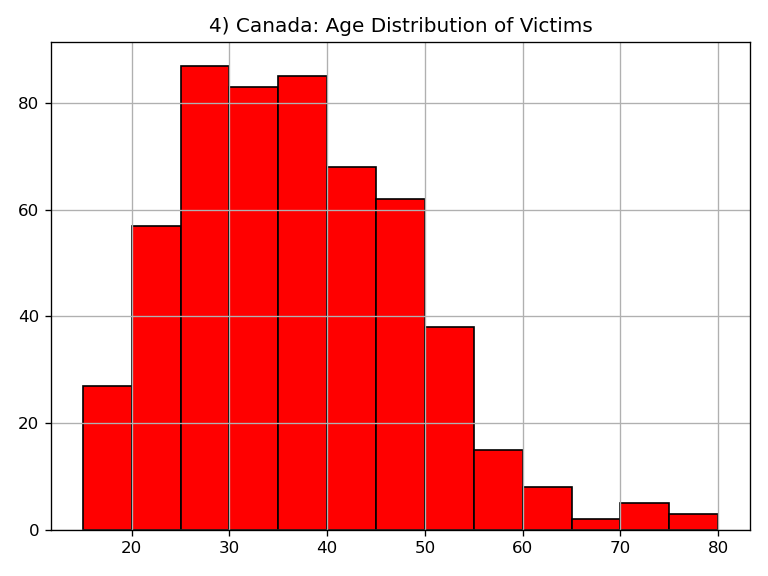

Unarmed/Did Not Have an Actual Weapon
Vehicle                                  0.066690
Unarmed/Did Not Have an Actual Weapon    0.218820
Allegedly Armed                          0.714489
Name: State, dtype: float64
ARMED TYPE
Firearm          0.187037
Knife            0.344444
None             0.292593
Other weapons    0.175926
Name: AGE, dtype: float64


In [28]:
CA_Total=Data.CA_PoliceKillings['AGE'].count()

fig,ax=plt.subplots(1,1)
ax.set_title('1) Canada: Police Killings by Year',loc='left')
ByYear=Data.CA_PoliceKillings.resample('YS').count()['AGE']
ax.bar(ByYear.index.year,ByYear.values,color=[1,0,0],edgecolor='k')
ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k')
plt.tight_layout()

fig,ax=plt.subplots(1,1)
ax.set_title('2) Canada: Race',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['AGE'].sort_values()
ax.barh(ByRace.index,ByRace.values,color=[1,0,0],edgecolor='k')
plt.tight_layout()

fig,ax=plt.subplots(1,1)
ax.set_title('3) Canada: Armed Type',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('ARMED TYPE').count()['AGE'].sort_values()
ax.pie(ByRace.values,labels=ByRace.index,
    autopct='%1.1f%%')
plt.tight_layout()

fig,ax=plt.subplots(1,1)
Data.CA_PoliceKillings['AGE'].hist(bins = np.arange(15,85,5),color=[1,0,0],edgecolor='k',ax=ax)
ax.set_title('4) Canada: Age Distribution of Victims')
plt.tight_layout()



# Which Police Department is most likely to kill an unarmed person?

In [68]:
from geopy.geocoders import MapBox
import folium
geolocator = MapBox(api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2ticGpkbXUxMHZyeTJzbDNpMGpjNWM5biJ9.B3AUQA9Qff8fo7gAo6NTvw")

CanadaMap = folium.Map(
    location=[60,-95.5],
    zoom_start=3,
)

# ARMED_TYPE_Types = Data.CA_PoliceKillings['ARMED TYPE'].unique()
# ARMED_TYPE = (Data.CA_PoliceKillings.groupby(['ARMED TYPE','PROV','POLICE SERVICE']).count()['AGE']).reset_index()

# ARMED_TYPE['Percent Unamred']=ARMED_TYPE[]

ARMED_TYPE=(Data.CA_PoliceKillings.groupby(['PROV','POLICE SERVICE','ARMED TYPE']).count()['AGE'].unstack())
Types = ARMED_TYPE.columns
ARMED_TYPE['Total']=ARMED_TYPE.sum(axis=1)
ARMED_TYPE['Unarmed%']=ARMED_TYPE['None']/ARMED_TYPE['Total']
ARMED_TYPE = ARMED_TYPE.fillna(0)
# print(Types,ARMED_TYPE['Unarmed%'].sort_values(ascending=False))
# print(ARMED_TYPE.loc[ARMED_TYPE['ARMED TYPE']=='None'].sort_values(by='AGE'))
# print(ARMED_TYPE.index.get_level_values(0))
for index,row in ARMED_TYPE.iterrows():
#     print(index,row)
# Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV']).count().sort_values(by='AGE').iterrows():
    try:
        Dept = geolocator.geocode(index[1]+', '+index[0]+', Canada')
        popuptext = '''<body> <h2>'''+index[1]+', '+Data.can_province_names[index[0]]+'''</h2> 
                        <table style="width:100%">
                        <tr>
                        <th>Weapon</th>
                        <th>Number of Killings &nbsp </th>
                        <th>Percentage of Total</th>
                        </tr>
                        '''
#         print(row['None'])
        for typ in Types:
            
#         for i,rval in zip(row.index,row):
#             print(i,rval)
#         ARMED_TYPE.loc[((ARMED_TYPE['POLICE SERVICE']==index[0])&(ARMED_TYPE['PROV']==index[1])),['ARMED TYPE','AGE']].sort_values(by='AGE').iterrows():

            popuptext+= '''<tr>
                        <td>'''+typ+''' &nbsp </td>
                        <td>'''+str(row[typ])+'''</td>
                        <td>'''+str(int(row[typ]/row['Total']*100))+'''%</td>
                        </tr>'''

        popuptext+='''<tr>
                  <th>Total </th>
                  <th>'''+str(row['Total'])+'''</th>
                  <th> </th>
                  </tr>'''
        text = folium.Html(popuptext, script=True)
        popup = folium.Popup(text, max_width=400,min_width=300)

        folium.CircleMarker(
                location=[Dept.latitude,Dept.longitude],
                radius=int(row['None']+1),
                popup=popup,
                fill_opacity = .5,
                fill=True,
                color='black',
                line_weight=.35,
                fill_color='red'
            ).add_to(CanadaMap)
    except:
        print('Could not GEOCODE:' ,index,row)
        pass
CanadaMap

Could not GEOCODE: ('QC', 'Service de police de la Ville de Lévis, Sûreté du Québec, Service de police de la Ville de Québec') ARMED TYPE
Firearm          0.0
Knife            1.0
None             0.0
Other weapons    0.0
Total            1.0
Unarmed%         0.0
Name: (QC, Service de police de la Ville de Lévis, Sûreté du Québec, Service de police de la Ville de Québec), dtype: float64


# Now the United States Data

<IPython.core.display.Javascript object>


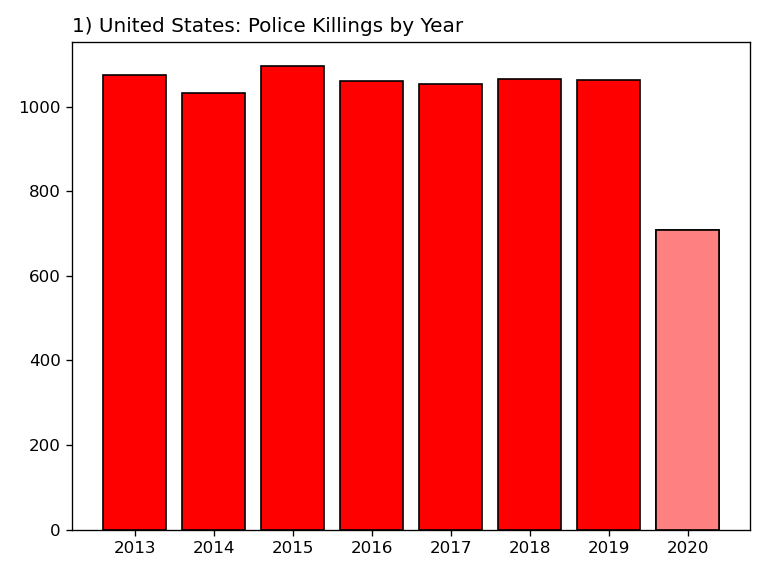

<IPython.core.display.Javascript object>


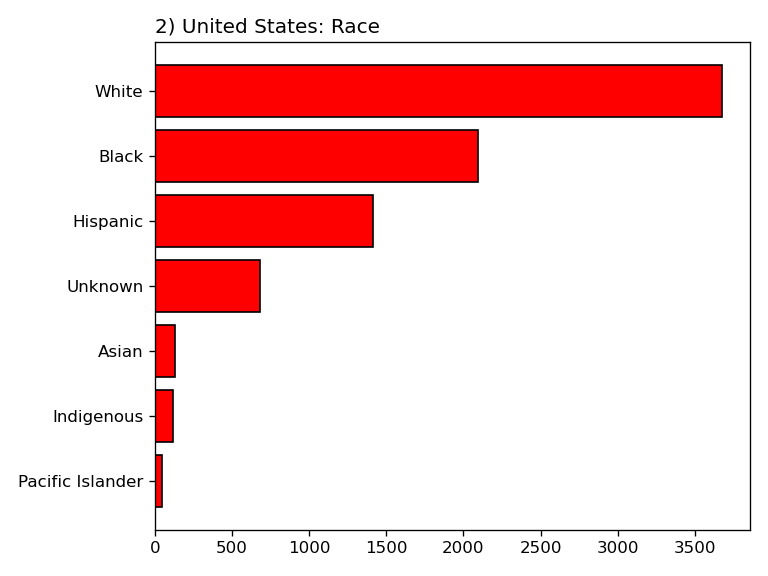

<IPython.core.display.Javascript object>


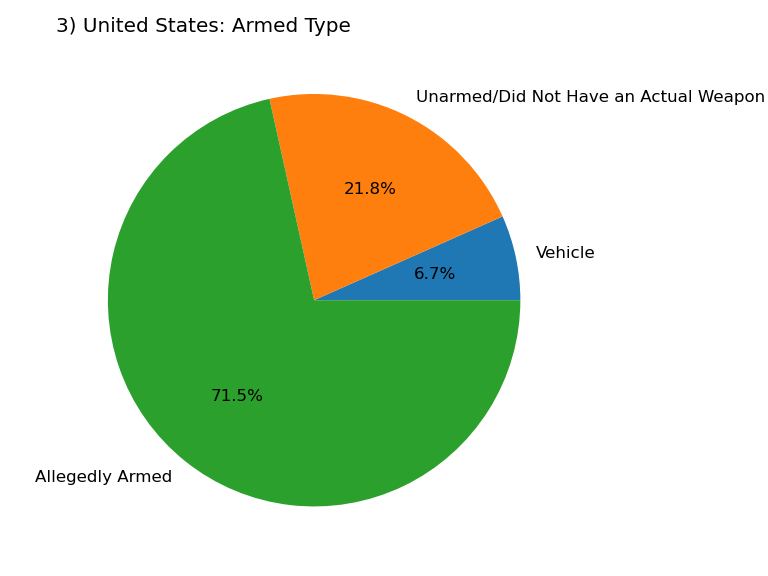

<IPython.core.display.Javascript object>


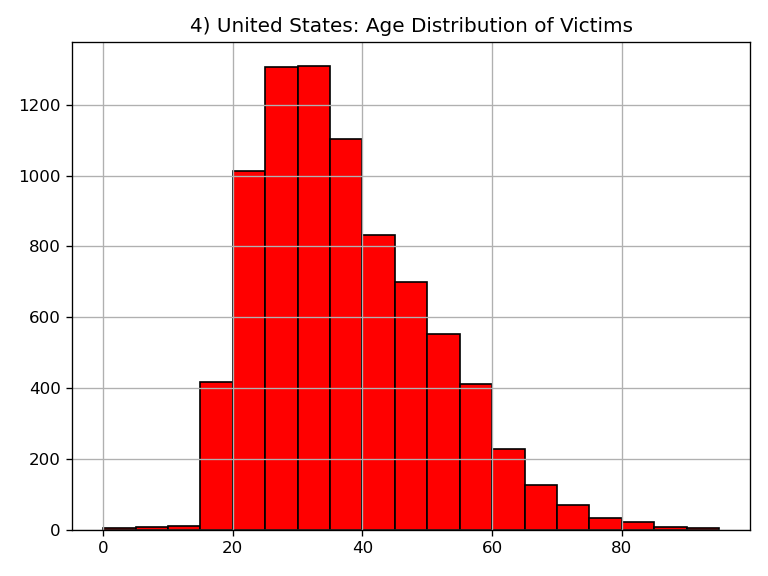

In [32]:
US_Total=Data.US_PoliceKillings["Victim's age"].count()

fig,ax=plt.subplots(1,1)
ax.set_title('1) United States: Police Killings by Year',loc='left')
ByYear=Data.US_PoliceKillings.resample('YS').count()['AGE']
ax.bar(ByYear.index.year,ByYear.values,color=[1,0,0],edgecolor='k')
ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k')
plt.tight_layout()

fig,ax=plt.subplots(1,1)
ax.set_title('2) United States: Race',loc='left')
ByRace=Data.US_PoliceKillings.groupby('RACE').count()['AGE'].sort_values()
ax.barh(ByRace.index,ByRace.values,color=[1,0,0],edgecolor='k')
plt.tight_layout()

fig,ax=plt.subplots(1,1)
ax.set_title('3) United States: Armed Type',loc='left')
ByRace=Data.US_PoliceKillings.groupby('Unarmed/Did Not Have an Actual Weapon').count()['AGE'].sort_values()
ax.pie(ByRace.values,labels=ByRace.index,
    autopct='%1.1f%%')
plt.tight_layout()

fig,ax=plt.subplots(1,1)
Data.US_PoliceKillings['AGE'].hist(bins = np.arange(0,100,5),color=[1,0,0],edgecolor='k',ax=ax)
ax.set_title('4) United States: Age Distribution of Victims')
plt.tight_layout()



# To get a better idea of whats going on, we need to Normalize our data.
* Normalization is when you take one number (ie. Total Police Killings) and divide it by other numbers (ie. Total Population)
    * Lets recreate graph 1, but we'll normalize our data population counts from the 2016 Canadian Census and 2018 US Census estimates

<IPython.core.display.Javascript object>


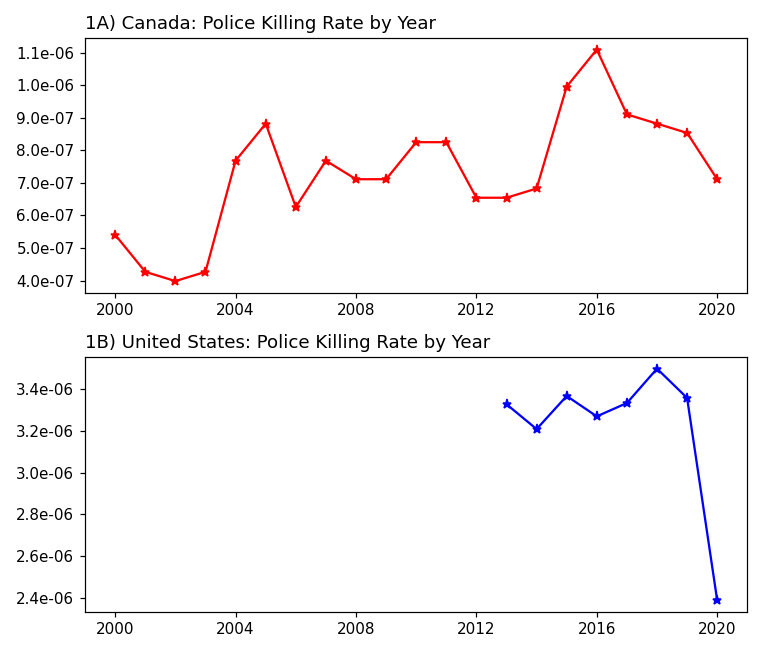

In [3]:

import matplotlib.ticker as mtick

fig,ax=plt.subplots(2,1,figsize=(7,6))
ax[0].set_title('1A) Canada: Police Killing Rate by Year',loc='left')
ByYear=Data.CA_PoliceKillings.resample('YS').count()['AGE']/Data.CA.Total.sum()
ax[0].plot(ByYear.index,ByYear.values,marker='*',color=[1,0,0])
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

ax[1].set_title('1B) United States: Police Killing Rate by Year',loc='left')
ByYear=Data.US_PoliceKillings.resample('YS').count()["Victim's age"]/Data.US.Total.sum()
ax[1].plot(ByYear.index,ByYear.values,marker='*',color=[0,0,1])
ax[1].set_xlim(ax[0].get_xlim())
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

plt.tight_layout()

# Notice that the numbers on the y axis are very small
* We've calculated the nubmer of police killings per person.  To make the numbers more inteilgible, we might want to scale them, by say 1 million (1e6) 


<IPython.core.display.Javascript object>


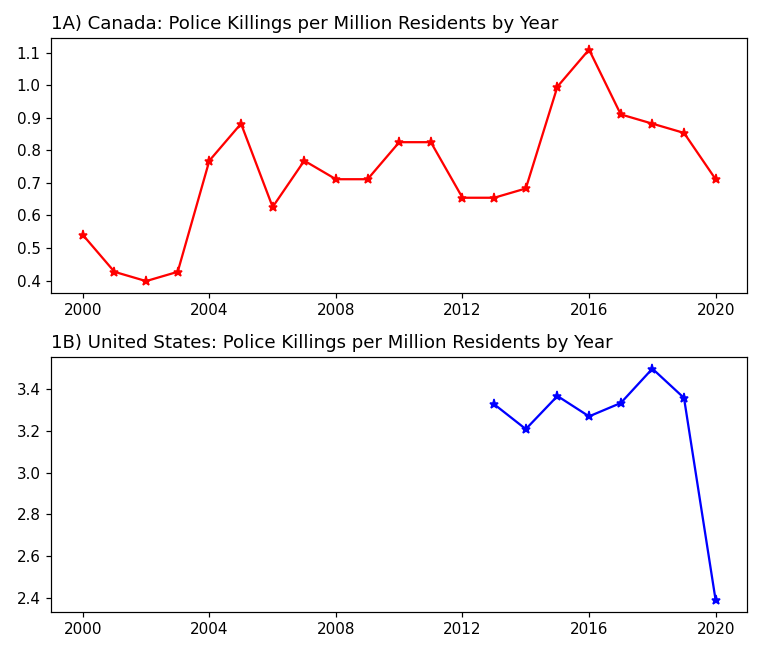

In [4]:
fig,ax=plt.subplots(2,1,figsize=(7,6))
ax[0].set_title('1A) Canada: Police Killings per Million Residents by Year',loc='left')
ByYear=Data.CA_PoliceKillings.resample('YS').count()['AGE']/Data.CA.Total.sum()*1e6
ax[0].plot(ByYear.index,ByYear.values,marker='*',color=[1,0,0])
# ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

ax[1].set_title('1B) United States: Police Killings per Million Residents by Year',loc='left')
ByYear=Data.US_PoliceKillings.resample('YS').count()["Victim's age"]/Data.US.Total.sum()*1e6
ax[1].plot(ByYear.index,ByYear.values,marker='*',color=[0,0,1])
ax[1].set_xlim(ax[0].get_xlim())
# ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

plt.tight_layout()

# To calculate the average rate over the whole dataset, we'll also need ot acount for the record legnth

So our normalization calculation would look like:
    
\begin{align}
\ Police Killing Rate & = (\frac{Total Police Killings}{Total Population * Record Length})* 1e6 \\
\end{align}

* Recreating plot #2 would look like:


<IPython.core.display.Javascript object>


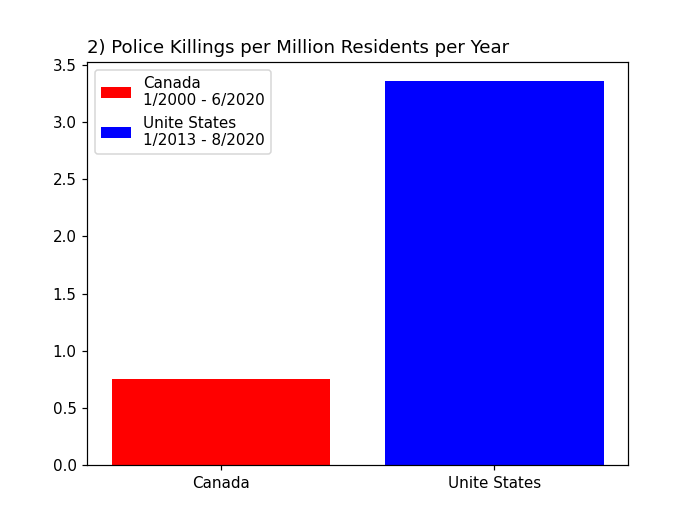

In [5]:
# fig,ax=plt.subplots()

CA_Rate = CA_Total /(Data.CA.Total.sum()*Data.CA_Length) * 1e6
US_Rate = US_Total /(Data.US.Total.sum()*Data.US_Length) * 1e6

# ax.bar([0,1],[CA_Rate,US_Rate])
# ax.set_xticks([0,1])
# ax.set_xticklabels(['Canadian Jan 2000 - June 2020',
#                     'Unite States Jan 2013 - Aug 2020'])
# ax.set_title('Police Killings per Million Residents per Year')



fig,ax=plt.subplots()
ax.bar([0],CA_Rate,color=[1,0,0],label='Canada\n1/2000 - 6/2020')
ax.bar([1],US_Rate,color=[0,0,1],label='Unite States\n1/2013 - 8/2020')
ax.set_xticks([0,1])
ax.set_xticklabels(['Canada','Unite States'])
ax.set_title('2) Police Killings per Million Residents per Year',loc='left')
ax.legend()
# print(US_Rate/CA_Rate)

# By normalizing, we can more directly compare the patterns between geographic regions with different characteristics (Population) and datasets of different lenghts

* We can see that Police Violence rates in the US are about 4.5 x higher than in Canada.
    
* But this doesn't tell us the full story either.  There is are significant racial disparities in the police killings on both sides of the border
    * Demographics are not evenly distributed within or between countries, so we need to acount for that with normalization
    * The Canadian census and Untied States census used different racial groupings so it is difficult to compare across all demographics.
    * The police violence datasets for each country also use slightly different demographic groupings than their respective censuses.
        * This makes the comparissons even less stragithforwar.
    * White, black, and indigenous are in both police violence datasets and are available from both sets of census data.
        * Whites are the majority in both contries, while black and indgenous people disporportionately impacted by police killings on both sides of the border.  So we'll focus on these three groups.
* One Caveat, the race of the victim is unknown for 24% of Canadian and 10% of United States.  This adds uncertainty to the comparison.  It also means that the Police Killing Rates by race are underestimated, especially for Canada
    * This is partly becasue these datasets were collected by third party organizations
        * The Canadian Data was collected by the CBC
        * The US Data was collected by the non-profit Mapping Police Violence
    * These datsets rely on media reports and are likely incomplete
    * Police departments and governments should be responsible for collecting and publishing this information to ensure better acountability, however police and governments around North America have failed to do so

Police Killing Rates:
                  US        CA
Total       3.353979  0.750329
White       2.046058  0.446725
Black       6.636197  1.956103
Indigenous  5.484477  2.597146


<IPython.core.display.Javascript object>


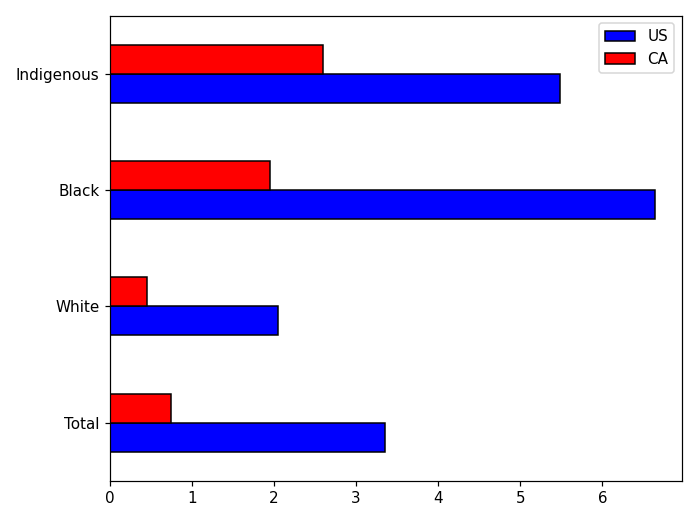

In [6]:
Data.ScaleData(scale=1e6)
print('Police Killing Rates:')
print(Data.Summary)

Data.Summary.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k')

plt.tight_layout()


# Scaled, to their respective populations, we can see that Indigenoun and Black people are much more likely to be killed by the police than white pople in both Canada and the United States
* The overal rates for each race are higher in the US than Canada
    * However the dispartiy between races is actually greater in Canada than the United States
    
* To show this, we can divide the black and indigenous rates fore each country by the white rate.
    * This will tell us how many times more likely a black or indigenous individual is to be killed by the police than a white individual in each country.
    * We can see that Indigenous and Black Canadians are 5.8 and 4.4 times more likely to be killied by police than a White Canadian
        * These disparities are higher than in the US
            * By this metric, you could suggest that police in Canada may be more racially biased than police in the US

# Systemic Racism in Policing is a Canadian Problem
* This issue isn't restricted to America, it's pervasive in Canada as well and can not be overlooked

                  US        CA
Black       3.243406  4.378760
Indigenous  2.680509  5.813743


<IPython.core.display.Javascript object>


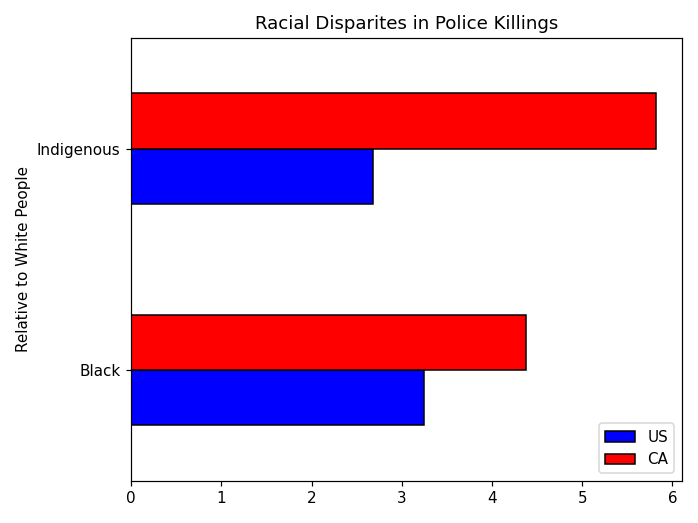

In [7]:
Ratio = Data.Summary.loc[Data.Summary.index=='Black']/Data.Summary.loc[Data.Summary.index=='White'].values
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='Indigenous']/Data.Summary.loc[Data.Summary.index=='White'].values)

print(Ratio)

Ratio.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k')
plt.title('Racial Disparites in Police Killings')
plt.ylabel('Relative to White People')
plt.tight_layout()
# print(Data.CA.columns)
# Ratio

# Histograms and Classification Schemes

* Rates vary by administrative divisoins, eg. (State/Province)
    * If we want to compare between states/provinces the first step is to look at histograms.
    
* A Histogram shows us the frequency distributioin of a given variable
    * Data is grouped into a set of bins
        * We can either specify a set number of bins or a specific bin with
* We'll combine the Canadain and United States data and look at a histogram of the total police violence rate



<IPython.core.display.Javascript object>


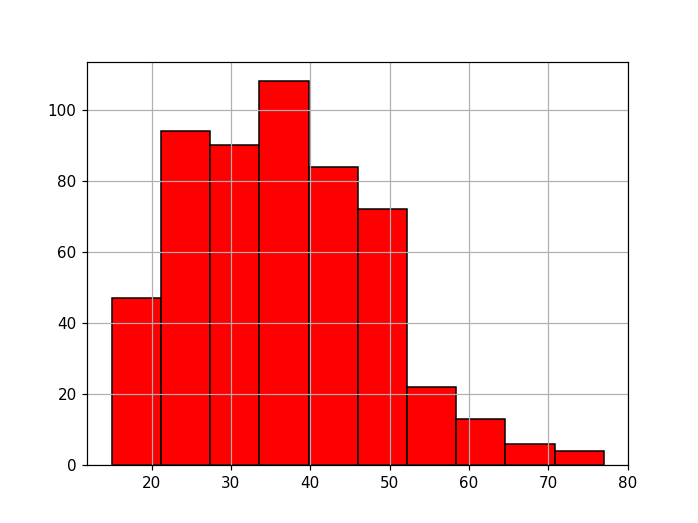

                                          DATE  NAME FIRST  NAME LAST  \
POLICE SERVICE                      PROV                                
Abbotsford Police Department        BC       1           1          1   
Amherstburg Police Service          ON       1           1          1   
Anishnabe Takonewini Police Service QC       2           2          2   
Barrie Police Services              ON       1           1          1   
Bathurst Police Force               NB       1           1          1   
...                                        ...         ...        ...   
Victoria Police Department          BC       3           3          3   
Waterloo Regional Police Service    ON       3           3          3   
Windsor Police Service              ON       2           2          2   
Winnipeg Police Service             MB      22          22         20   
York Regional Police                ON       9           9          5   

                                          NAME MID

In [8]:
# plt.figure()
import numpy as np
gig,ax=plt.subplots()#1,2)
Data.CA_PoliceKillings['AGE'].hist(ax=ax,color=[1,0,0],edgecolor='k')
print(Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV']).count())
# Data.CA_PoliceKillings['AGE'].hist(ax=ax[0],color=[1,0,0],edgecolor='k')
# Data.US_PoliceKillings['AGE'].hist(ax=ax[1],color=[0,0,1],edgecolor='k')


# ax[1].set_yscale('symlog')
# print(ax[1].get_xticks())
# ax[1].set_xticks(np.arange(10,90,10))
# Temp = Data.US['Total_Rate']
# Temp = Temp.append(Data.CA['Total_Rate'])

# plt.figure()
# Temp.hist(color='grey',edgecolor='k',bins=15)
# plt.title('Police Killing Rates by US State / CA Province')


In [13]:
from geopy.geocoders import MapBox
import folium
geolocator = MapBox(api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2ticGpkbXUxMHZyeTJzbDNpMGpjNWM5biJ9.B3AUQA9Qff8fo7gAo6NTvw")

CanadaMap = folium.Map(
    location=[60,-95.5],
    zoom_start=3,
)

RACE_Types = Data.CA_PoliceKillings['RACE'].unique()
RACE = (Data.CA_PoliceKillings.groupby(['RACE','PROV','POLICE SERVICE']).count()['AGE']).reset_index()


for index,row in Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV']).count().sort_values(by='AGE').iterrows():
    try:
        Dept = geolocator.geocode(index[0]+', '+index[1]+', Canada')
        popuptext = '''<body> <h2>'''+index[0]+', '+Data.can_province_names[index[1]]+'''</h2> 
                        <table style="width:100%">
                        <tr>
                        <th>Race</th>
                        <th>Number of Killings &nbsp </th>
                        <th>Percentage of Total</th>
                        </tr>
                        '''
        for i,rval in RACE.loc[((RACE['POLICE SERVICE']==index[0])&(RACE['PROV']==index[1])),['RACE','AGE']].sort_values(by='AGE').iterrows():

            popuptext+= '''<tr>
                        <td>'''+rval['RACE']+''' &nbsp </td>
                        <td>'''+str(rval['AGE'])+'''</td>
                        <td>'''+str(int(rval['AGE']/row['AGE']*100))+'''%</td>
                        </tr>'''

        popuptext+='''<tr>
                  <th>Total </th>
                  <th>'''+str(row['AGE'])+'''</th>
                  <th> </th>
                  </tr>'''
        text = folium.Html(popuptext, script=True)
        popup = folium.Popup(text, max_width=400,min_width=300)

        folium.CircleMarker(
                location=[Dept.latitude,Dept.longitude],
                radius=int(row['AGE']/2+1),
                popup=popup,
                fill_opacity = .5,
                fill=True,
                color='black',
                line_weight=.35,
                fill_color='red'
            ).add_to(CanadaMap)
    except:
        print('Could not GEOCODE:' ,index,row)
        pass
CanadaMap

Could not GEOCODE: ('Service de police de la Ville de Lévis, Sûreté du Québec, Service de police de la Ville de Québec', 'QC') DATE              1
NAME FIRST        1
NAME LAST         1
NAME MIDDLE       0
NICKNAME          0
AGE               1
GENDER            1
RACE              1
CAUSE DEATH       1
ARMED TYPE        1
PICTURE SOURCE    0
SUMMARY           1
Year              1
Name: (Service de police de la Ville de Lévis, Sûreté du Québec, Service de police de la Ville de Québec, QC), dtype: int64


In [14]:
CanadaMap.save('CanadianPoliceViolenceIncidents.html')

<IPython.core.display.Javascript object>


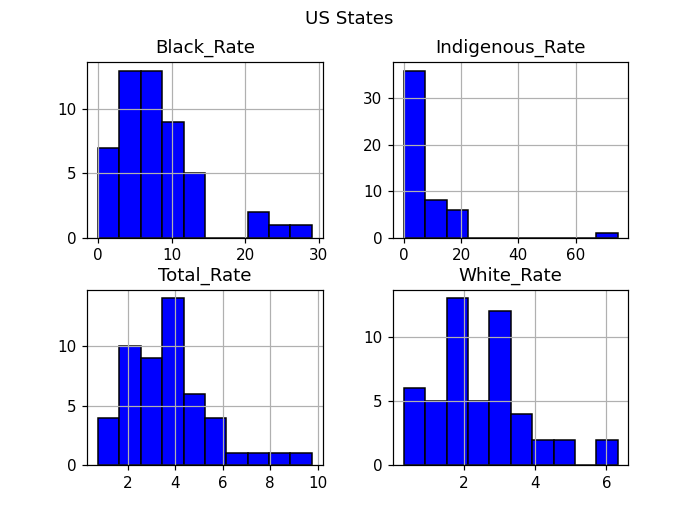

<IPython.core.display.Javascript object>


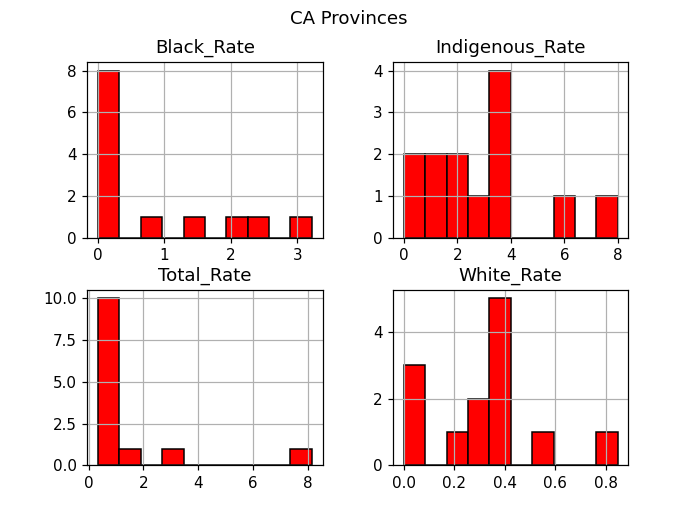

<IPython.core.display.Javascript object>


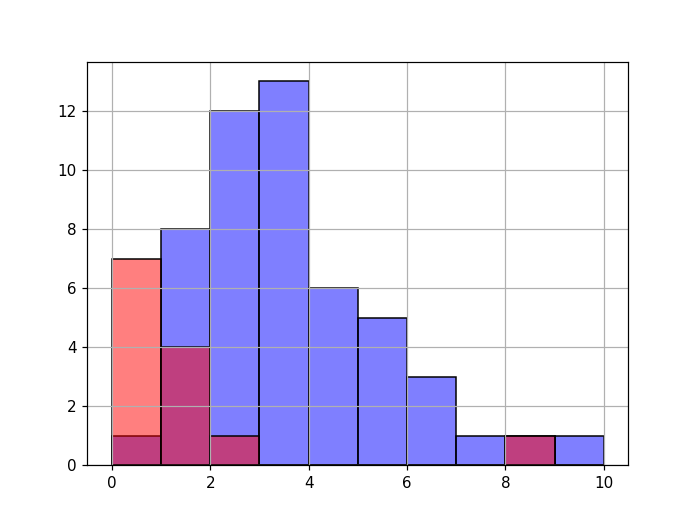

In [11]:

# Data.US['Total_Rate'].hist(ax=ax,color=[.05,.05,1,.5],edgecolor='k',linewidth=.5,bins=10)
# Data.CA['Total_Rate'].hist(ax=ax,color=[1,.0,.0,.5],edgecolor='k',linewidth=.5,bins=10)
# plt.figure()
Data.US[['Indigenous_Rate','Black_Rate','White_Rate','Total_Rate']].hist(color=[0,0,1],edgecolor='k',bins=10)
plt.suptitle('US States')


Data.CA[['Indigenous_Rate','Black_Rate','White_Rate','Total_Rate']].hist(color=[1,0,0],edgecolor='k',bins=10)
plt.suptitle('CA Provinces')



fig,ax=plt.subplots()

Data.US['Total_Rate'].hist(bins=np.arange(0,11,1),color=[0,0,1,.5],edgecolor='k')

Data.CA['Total_Rate'].hist(bins=np.arange(0,11,1),color=[1,0,0,.5],edgecolor='k')

<IPython.core.display.Javascript object>


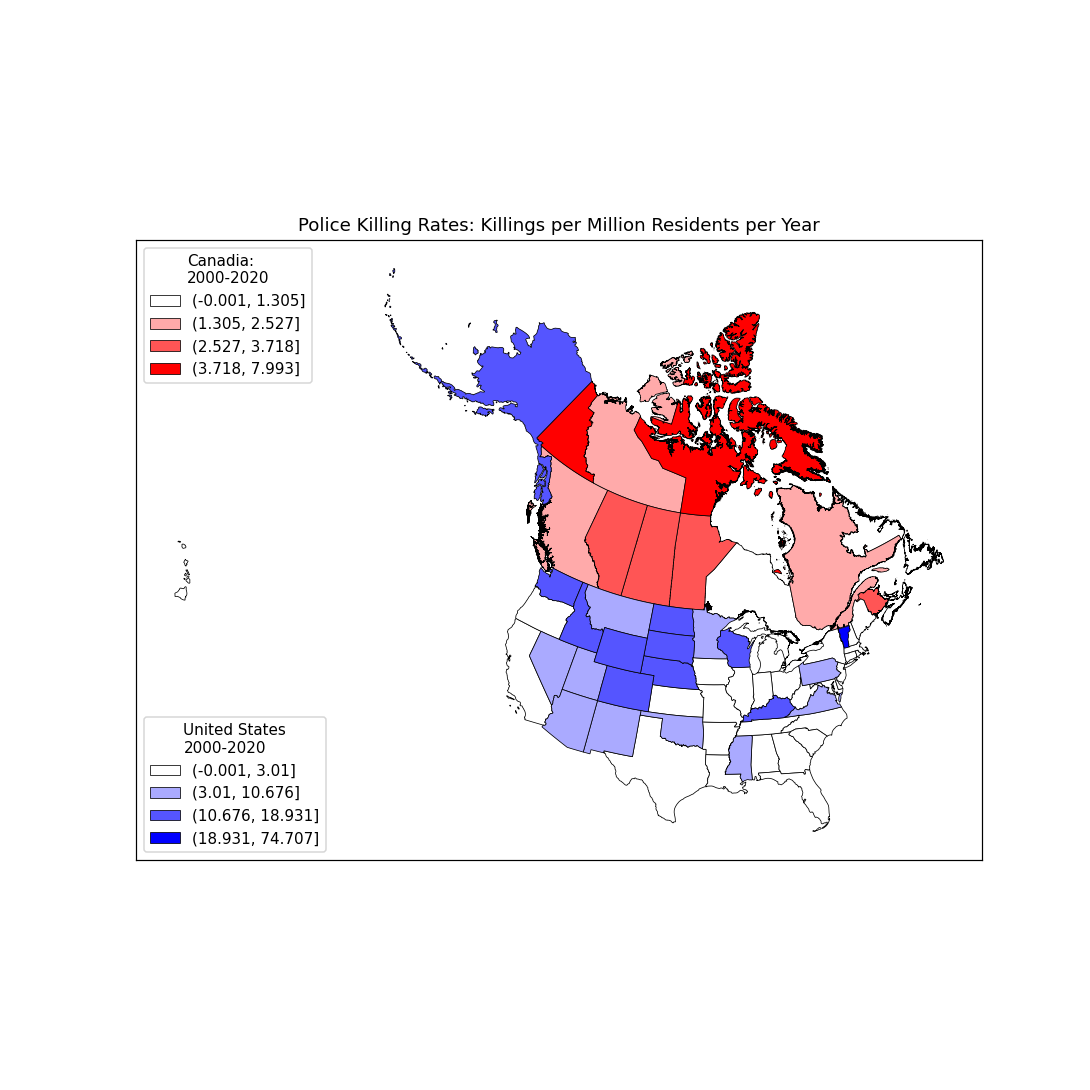

#ffffff
#ffaaaa
#ff5555
#ff0000


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj

Text(0.5, 1.0, 'Police Killing Rates: Killings per Million Residents per Year')

In [12]:
import matplotlib
import matplotlib.patches as mpatches

Rate = 'Indigenous'+'_'
n_classes=4
Data.NaturalBreaks(column=Rate+'Rate',classes=n_classes)
labels=Data.CA[Rate+'Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([1,1-c/(n_classes-1),1-c/(n_classes-1)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)


fig,ax=plt.subplots(figsize=(10,10))
CA_Patches = []
for klass in Data.CA[Rate+'Rate_NB'].unique().sort_values():
    print(CA_Color[klass])
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
    Data.CA.loc[Data.CA[Rate+'Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    CA_Patches.append(mpatches.Patch(**kwargs))

    
labels=Data.US[Rate+'Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([1-c/(n_classes-1),1-c/(n_classes-1),1]))
US_Color = {key:value for key,value in zip(labels,colors)}

US_Patches = [] 
for klass in Data.US[Rate+'Rate_NB'].unique().sort_values():
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
    Data.US.to_crs(Data.CA.crs).loc[Data.US[Rate+'Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    US_Patches.append(mpatches.Patch(**kwargs))
    
first_legend = plt.legend(handles=CA_Patches, loc='upper left',
      title='Canadia:\n2000-2020')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=US_Patches, loc='lower left',
      title='United States\n2000-2020')

plt.show()
    
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Police Killing Rates: Killings per Million Residents per Year')

# Data.CA.plot(
#     column=Rate+'Rate_NB',
#     cmap = 'Blues',
#     edgecolor='black',
#     linewidth=.5,
#     ax=ax)
# Data.US.to_crs(Data.CA.crs).plot(
#     column=Rate+'Rate_NB',
#     cmap = 'Reds',
#     edgecolor='black',
#     linewidth=.5,
#     ax=ax)

In [13]:
# Data.NaturalBreaks(column='Indigenous_Rate',classes=5)
# print(Data.CA['Indigenous_Rate'])
# labels=Data.CA['Indigenous_Rate_NB'].unique().sort_values()
# print(labels)

Data.US[['Indigenous','Indigenous_Killings','Indigenous_Rate']].sort_values('Indigenous')

,Indigenous,Indigenous_Killings,Indigenous_Rate
STUSPS,,,
VT,1743,1.0,74.706772
DC,1932,NaN,0.000000
WV,2629,NaN,0.000000
HI,3237,NaN,0.000000
NH,3562,NaN,0.000000
RI,4341,NaN,0.000000
DE,4397,NaN,0.000000
KY,8470,1.0,15.373542
ME,8566,NaN,0.000000
